In [1]:
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together


### Define functions

In [2]:
def log_mass_size(df):
    '''
    Converts to log10 non-zero size and mass entries (without distinguishing galaxy type)
    output: df with new columns of log mass, log size added to it

    '''
    #first let's remove all galaxy_mass=0 since you are going to at the end anyway
    df=df[df['mstar'] > 0]

#     #subhalo_flag = subhalos[‘SubhaloFlag’]
#     if type_of_galaxy == 'central':
#         df=df[df['subhalo_flag']==True]
#     elif type_of_galaxy == 'satellite':
#         df=df[df['subhalo_flag']==False]
#     else: 
#         print("type_of_galaxy must be set to central or satellite")

    #since we got rid of all zero mass we can just take the log10
    df.loc[:, 'mstar_log']=np.log10(df.loc[:, 'mstar'])
    df.loc[:, 'half_radius_log']=np.log10(df.loc[:, 'half_radius'])
    df.loc[:, 'mhalo_log']=np.log10(df.loc[:, 'mhalo'])
    df.loc[:, 'Mhot_log']=np.log10(df.loc[:, 'Mhot'])
    df.loc[:,'mbulge_log']=df.loc[:,'mbulge'].apply(lambda x: np.log10(x) if x>0 else 0) # because there are 0 values of mbulge

    return df

In [3]:
def log_SFR(df):
    '''
    Converts to log10 non-zero SFR entries (without distinguishing galaxy type)
    output: df with new columns of log SFR added to it

    '''
    #first let's remove all galaxy_mass=0 since you are going to at the end anyway
    df=df[df['sfr'] > 0]

    #since we got rid of all zero mass we can just take the log10
    df['sfr_log']=np.log10(df['sfr'])

    return df

In [4]:
# function to return the base 10 logarithm of non-zero values
def return_log(row, col):
    if(row[col]!= 0):
        return np.log10(row[col])
    else:
        return 0

In [5]:
# function to return the base 10 logarithm of non-zero values
def return_log_SFR(row, col):
    if(row[col]!= 0):
        return np.log10(row[col])
    else:
        return -2

In [6]:
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

### <font color='blue'> Define data frame

In [7]:
df=pd.read_hdf('./tng-sam_v2.h5') 


In [8]:
df

,mhalo,spin,Cnfw,Mhot,Macc,mstar,mHI,mH2,mbulge,r_bulge,r_disk,sfr,Zcold,Zstar,sat_type
0,8.945970e+08,0.03410,27.518700,1.150910e+08,0.0,1.918680e+04,1443460.0,350.895996,1.705140e+03,1.380600e-07,0.612071,2.099810e-07,6.425340e-06,1.847320e-08,0.0
1,1.815770e+09,0.04884,25.676800,9.966590e+07,0.0,5.311550e+05,1239300.0,574.640991,9.893530e+04,3.582890e-04,1.109940,3.485530e-07,5.455150e-05,2.259670e-06,0.0
2,4.880430e+09,0.07510,24.664200,1.409960e+07,0.0,1.461610e+06,51356600.0,120703.000000,2.745250e+05,3.465510e-03,1.129830,7.226970e-05,6.013470e-04,7.569950e-06,0.0
3,1.860050e+09,0.03953,19.896200,1.573440e+08,0.0,5.375590e+03,3270910.0,381.580017,2.401990e+03,5.426130e-08,0.905608,2.283380e-07,5.815860e-06,2.387450e-09,0.0
4,1.615000e+09,0.04429,28.457001,1.273490e+08,0.0,1.164560e+04,655190.0,66.861099,0.000000e+00,0.000000e+00,0.967984,4.000970e-08,6.864240e-06,1.009730e-08,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924830,8.857400e+08,0.01890,24.130699,9.038510e+07,0.0,1.155000e+03,274128.0,58.854900,4.672700e+01,1.623750e-10,0.357797,3.521890e-08,9.629620e-07,3.182000e-10,0.0
1924831,9.477410e+08,0.04871,18.530899,9.490910e+07,0.0,0.000000e+00,0.0,0.000000,0.000000e+00,0.000000e+00,0.891291,0.000000e+00,0.000000e+00,0.000000e+00,0.0
1924832,1.617950e+09,0.03615,34.817600,1.473450e+08,0.0,6.519520e+03,589709.0,66.945503,1.819190e+03,1.039700e-07,0.790560,4.069460e-08,5.339940e-06,3.317030e-09,0.0
1924833,2.970180e+09,0.01930,15.964400,1.480060e+08,0.0,6.943700e+04,15834101.0,7420.919922,4.825620e+03,4.585310e-07,0.535545,4.442270e-06,3.334850e-05,9.543090e-08,0.0


#### mhalo = mass of halo, spin=halo spin, Mhot=hot gas mass of the halo, mstar=stellar mass, sfr=instantaneous sfr, Zcold=cold gas metallicity, Zstar=star metallicity

In [9]:
df.shape

(1924835, 15)

In [10]:
df['sat_type'].value_counts() # sat_type=0 corresponds to CENTRAL galaxies; 1,346,899 central galaxies

0.0    1346899
1.0     475176
2.0      91982
3.0      10122
4.0        611
5.0         45
Name: sat_type, dtype: int64

In [11]:
df['spin'].value_counts()

0.02100    11479
0.01267    10091
0.03045     8739
0.04980     6085
0.04623     5652
           ...  
0.15305        1
0.13308        1
0.12000        1
0.14137        1
0.16206        1
Name: spin, Length: 15680, dtype: int64

In [12]:
# df.columns.tolist()

### <font color='blue'> Filter the dataset

#### Mass filter

In [13]:
# remove all galaxies with stellar mass < 1e8
df_mass_filtered = df.loc[df.mstar>1e8,:]

In [14]:
df_mass_filtered.shape # 51,906 galaxies with stellar mass >1e8

(51906, 15)

#### Type filter (choose centrals only)

In [15]:
df_mass_filtered['sat_type'].value_counts() # 35,390 central galaxies with stellar mass >1e8

0.0    35390
1.0    13686
2.0     2540
3.0      271
4.0       18
5.0        1
Name: sat_type, dtype: int64

In [16]:
df_central=df_mass_filtered.loc[df_mass_filtered.sat_type==0,:] # choose only CENTRALs

In [17]:
df_central

,mhalo,spin,Cnfw,Mhot,Macc,mstar,mHI,mH2,mbulge,r_bulge,r_disk,sfr,Zcold,Zstar,sat_type
53,4.502510e+09,0.03378,59.129101,9.503960e+09,0.0,1.050790e+08,2.710510e-11,0.0,72604704.0,0.503721,1.03908,0.000402,0.000008,0.004245,0.0
59,1.285310e+11,0.03407,21.878799,8.516240e+05,0.0,2.136860e+09,4.310100e+08,145516000.0,231256000.0,1.340100,1.44021,0.101277,0.206532,0.485612,0.0
82,1.171930e+11,0.01407,23.447201,5.588210e+05,0.0,1.583780e+09,3.059520e+08,46185400.0,240634992.0,1.801320,1.82321,0.028763,0.099900,0.308089,0.0
98,1.705850e+11,0.02229,17.701000,1.107320e+06,0.0,1.241640e+09,5.498750e+08,68248200.0,323452000.0,2.040110,2.30283,0.042378,0.160787,0.204719,0.0
104,8.294760e+10,0.01128,42.640499,1.935800e+05,0.0,1.432650e+09,1.699390e+08,24481200.0,490328000.0,1.414440,1.62481,0.015081,0.061155,0.310911,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1918905,5.192210e+10,0.03800,24.981800,3.574300e+04,0.0,1.312080e+08,2.422220e+08,7387440.0,7870290.5,0.861413,2.64082,0.004443,0.028542,0.007200,0.0
1918910,5.454680e+10,0.04917,16.239500,4.573560e+08,0.0,1.234320e+08,2.204080e+08,4975330.0,10646200.0,1.976380,3.47372,0.002984,0.036281,0.005770,0.0
1918945,5.175670e+10,0.03464,20.015400,1.392480e+08,0.0,1.227350e+08,4.174370e+08,75087504.0,20440200.0,0.553882,1.15671,0.051229,0.026656,0.006112,0.0
1918947,5.431060e+10,0.04613,20.577600,2.903790e+07,0.0,1.518140e+08,4.901590e+08,39315300.0,17960600.0,0.168341,1.62632,0.024660,0.041628,0.009348,0.0


In [18]:
df_central['sat_type'].value_counts()

0.0    35390
Name: sat_type, dtype: int64

In [19]:
np.log10(df_central['mstar'].max())

11.960914

In [20]:
np.log10(df_central['mhalo'].max())

14.686748

#### Filters using other properties

In [23]:
df_central[df_central['Zcold']<3].shape

(31688, 15)

In [23]:
35390-31688 # 3,702 galaxies with Zcold>3 

3702

In [24]:
df_central = df_central.loc[df_central.Zcold<3,:]

In [25]:
df_central.shape

(31688, 15)

In [26]:
31688-29781 # 1,907 galaxies with Zstar>3 remaining after filtering out galaxies with Zcold>3

1907

In [27]:
df_central = df_central.loc[df_central.Zstar<3,:] #remove galaxies with Zstar>3

In [28]:
df_central.shape

(29781, 15)

In [29]:
df_central = df_central.loc[df_central.mbulge>0.0,:] # remove all 5 entries where mbulge=0

In [30]:
df_central.shape

(29776, 15)

In [31]:
np.log10(df_central['mstar'].max()) # removing galaxies with Z>3 changes mstar(max) from 11.9 to 9.6, and mhalo(max) from ~14 to 12.6

9.960946

In [32]:
np.log10(df_central['mhalo'].max())

12.583929

In [33]:
df_central[df_central['Cnfw']<55].shape

(29570, 15)

In [34]:
df_central = df_central.loc[df_central.Cnfw<55,:] # remove all entries where Cnfw>55

In [35]:
df_central

,mhalo,spin,Cnfw,Mhot,Macc,mstar,mHI,mH2,mbulge,r_bulge,r_disk,sfr,Zcold,Zstar,sat_type
59,1.285310e+11,0.03407,21.878799,8.516240e+05,0.0,2.136860e+09,431010016.0,145516000.0,231256000.0,1.340100,1.44021,0.101277,0.206532,0.485612,0.0
82,1.171930e+11,0.01407,23.447201,5.588210e+05,0.0,1.583780e+09,305952000.0,46185400.0,240634992.0,1.801320,1.82321,0.028763,0.099900,0.308089,0.0
98,1.705850e+11,0.02229,17.701000,1.107320e+06,0.0,1.241640e+09,549875008.0,68248200.0,323452000.0,2.040110,2.30283,0.042378,0.160787,0.204719,0.0
104,8.294760e+10,0.01128,42.640499,1.935800e+05,0.0,1.432650e+09,169938992.0,24481200.0,490328000.0,1.414440,1.62481,0.015081,0.061155,0.310911,0.0
107,5.144180e+10,0.04394,33.175900,5.051540e+04,0.0,3.620070e+08,42364200.0,227020.0,100920000.0,0.362021,3.04418,0.003118,0.014877,0.030209,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1918905,5.192210e+10,0.03800,24.981800,3.574300e+04,0.0,1.312080e+08,242222000.0,7387440.0,7870290.5,0.861413,2.64082,0.004443,0.028542,0.007200,0.0
1918910,5.454680e+10,0.04917,16.239500,4.573560e+08,0.0,1.234320e+08,220408000.0,4975330.0,10646200.0,1.976380,3.47372,0.002984,0.036281,0.005770,0.0
1918945,5.175670e+10,0.03464,20.015400,1.392480e+08,0.0,1.227350e+08,417436992.0,75087504.0,20440200.0,0.553882,1.15671,0.051229,0.026656,0.006112,0.0
1918947,5.431060e+10,0.04613,20.577600,2.903790e+07,0.0,1.518140e+08,490159008.0,39315300.0,17960600.0,0.168341,1.62632,0.024660,0.041628,0.009348,0.0


In [36]:
np.log10(df_central['mstar'].max()) # removing all entries with Cnfw>55 doesn't change the max of mstar & mhalo

9.960946

In [37]:
np.log10(df_central['mhalo'].max())

12.583929

### <font color='blue'> Add half_radius by applying half_mass_radius function to each row

In [21]:
# import numpy as np
import matplotlib.pyplot as plt
import galsim #install with conda install -c conda_forge galsim

def half_mass_radius(mstar,mbulge,r_disk,r_bulge,tol=1.e-6,figure=False):
    '''calculate half mass radius for disk(n=1)+bulge(n=4) galaxy
    using bisection'''
    
    Md=mstar-mbulge # disk mass=stellar mass - bulge mass
    Rd=r_disk # disk radius
    Mb=mbulge # bulge mass
    Rb=r_bulge # bulge radius
    
    disk_fraction=Md/(Md+Mb)
    bulge_fraction=Mb/(Md+Mb)
    if bulge_fraction==0:
        disk=galsim.Sersic(scale_radius=Rd,n=1)  
        return disk.half_light_radius     
    if disk_fraction==0:
        return Rb
    disk=galsim.Sersic(scale_radius=Rd,n=1)
    bulge=galsim.Sersic(half_light_radius=Rb,n=4)
    #starting points for bisection
    a=bulge.half_light_radius
    b=disk.half_light_radius
    if b < a:
        a=disk.half_light_radius
        b=bulge.half_light_radius

    #bisection
    Ma=disk_fraction*disk.calculateIntegratedFlux(a)+bulge_fraction*bulge.calculateIntegratedFlux(a)
    Mb=disk_fraction*disk.calculateIntegratedFlux(b)+bulge_fraction*bulge.calculateIntegratedFlux(b)
    if np.sign(Ma-0.5)==np.sign(Mb-0.5):
        raise Exception("a and b do not bound a root")
    while(b-a > tol):
        m=0.5*(a+b)
        f=(disk_fraction*disk.calculateIntegratedFlux(m)+
            bulge_fraction*bulge.calculateIntegratedFlux(m))-0.5
        if np.sign(f)==1:
            b=m
        else:
            a=m
    half_radius=0.5*(a+b)
    if figure:
        half=np.array([0.45,0.55]) #used for half marks
        R=np.arange(0,3*b,0.02)
        N=len(R)
        yd=np.zeros(N)
        yb=np.zeros(N)
        for i in range(N):
            yd[i]=disk_fraction*disk.calculateIntegratedFlux(R[i])
            yb[i]=bulge_fraction*bulge.calculateIntegratedFlux(R[i])
        plt.plot(R,yd,color='b',label='disk')
        plt.plot(R,yb,color='r',label='bulge')
        plt.plot(R,yd+yb,color='k',label='total')
        plt.plot([bulge.half_light_radius,bulge.half_light_radius],bulge_fraction*half,color='g')
        plt.plot([disk.half_light_radius,disk.half_light_radius],disk_fraction*half,color='g')
        plt.plot([half_radius,half_radius],half,color='g')
        plt.xlim([0,3*b])
        plt.ylim([0,1.0])
        plt.legend()
        plt.show()
    return half_radius

# if __name__=='__main__':
#     print(half_mass_radius(1.e10,3.5,0.e9,0.0,figure=True))

In [22]:
df_central.iloc[101,:]

mhalo       6.778860e+10
spin        2.908000e-02
Cnfw        8.621200e+00
Mhot        2.139400e+07
Macc        0.000000e+00
mstar       1.449540e+09
mHI         0.000000e+00
mH2         0.000000e+00
mbulge      1.439710e+09
r_bulge     3.956790e-01
r_disk      2.208780e+00
sfr         6.302250e-02
Zcold       1.938820e-03
Zstar       1.716930e+00
sat_type    0.000000e+00
Name: 2093, dtype: float32

In [23]:
#for i,row in df_central.iterrows():
df_central.loc[:,'half_radius'] = df_central.apply(lambda x: half_mass_radius(mstar=x['mstar'],mbulge=x['mbulge'],r_disk=x['r_disk'],r_bulge=x['r_bulge'],tol=1.e-6,figure=False), axis=1)

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [24]:
df_central['half_radius']

53         0.829693
59         2.332662
82         2.922134
98         3.491710
104        2.360157
             ...   
1918905    4.229993
1918910    5.548773
1918945    1.729907
1918947    2.406906
1918957    2.117134
Name: half_radius, Length: 35390, dtype: float64

In [25]:
# solution of the same problem using a for loop over the df rows
lst = []
for i,row in df_central.iterrows():
    result_iter = half_mass_radius(mstar=row['mstar'],mbulge=row['mbulge'],r_disk=row['r_disk'],r_bulge=row['r_bulge'],tol=1.e-6,figure=False)
    lst.append(result_iter)
    if i>100:
        break
               

In [26]:
lst

[0.8296922716638879,
 2.3326619620962354,
 2.922134029718011,
 3.4917102387445444,
 2.3601561747952067]

### <font color='blue'> Logarithmic scale of stellar mass, SFR, Mhalo

In [27]:
df_central.head(2)

,mhalo,spin,Cnfw,Mhot,Macc,mstar,mHI,mH2,mbulge,r_bulge,r_disk,sfr,Zcold,Zstar,sat_type,half_radius
53,4.502510e+09,0.03378,59.129101,9.503960e+09,0.0,1.050790e+08,2.710510e-11,0.0,72604704.0,0.503721,1.03908,0.000402,0.000008,0.004245,0.0,0.829693
59,1.285310e+11,0.03407,21.878799,8.516240e+05,0.0,2.136860e+09,4.310100e+08,145516000.0,231256000.0,1.340100,1.44021,0.101277,0.206532,0.485612,0.0,2.332662


In [28]:
df_central_log=log_mass_size(df_central)

In [29]:
df_central_log.head(2)

,mhalo,spin,Cnfw,Mhot,Macc,mstar,mHI,mH2,mbulge,r_bulge,...,sfr,Zcold,Zstar,sat_type,half_radius,mstar_log,half_radius_log,mhalo_log,Mhot_log,mbulge_log
53,4.502510e+09,0.03378,59.129101,9.503960e+09,0.0,1.050790e+08,2.710510e-11,0.0,72604704.0,0.503721,...,0.000402,0.000008,0.004245,0.0,0.829693,8.021516,-0.081083,9.653455,9.977904,7.860965
59,1.285310e+11,0.03407,21.878799,8.516240e+05,0.0,2.136860e+09,4.310100e+08,145516000.0,231256000.0,1.340100,...,0.101277,0.206532,0.485612,0.0,2.332662,9.329776,0.367852,11.109008,5.930248,8.364093


In [30]:
df_central_log['mbulge_log'].max()

11.92681558852368

In [31]:
df_central_log['mbulge_log'].min()

0.0

In [32]:
# add a column with the logarithmic value of SFR, setting any SFR=0 to a fixed value of -2
df_central_log['SFR_log'] = df_central_log.apply(lambda row: return_log_SFR(row, 'sfr'), axis=1)

In [33]:
df_central_log.head(2)

,mhalo,spin,Cnfw,Mhot,Macc,mstar,mHI,mH2,mbulge,r_bulge,...,Zcold,Zstar,sat_type,half_radius,mstar_log,half_radius_log,mhalo_log,Mhot_log,mbulge_log,SFR_log
53,4.502510e+09,0.03378,59.129101,9.503960e+09,0.0,1.050790e+08,2.710510e-11,0.0,72604704.0,0.503721,...,0.000008,0.004245,0.0,0.829693,8.021516,-0.081083,9.653455,9.977904,7.860965,-3.395986
59,1.285310e+11,0.03407,21.878799,8.516240e+05,0.0,2.136860e+09,4.310100e+08,145516000.0,231256000.0,1.340100,...,0.206532,0.485612,0.0,2.332662,9.329776,0.367852,11.109008,5.930248,8.364093,-0.994489


### Gas fraction

In [34]:
df_central_log['neutral_H_mass']=(df_central_log['mHI']+df_central_log['mH2'])
df_central_log['baryon_mass']=df_central_log['neutral_H_mass']+df_central_log['mstar']
df_central_log['gas_fraction']=df_central_log['neutral_H_mass']/df_central_log['baryon_mass']

In [35]:
df_central_log.shape

(35390, 25)

In [36]:
np.count_nonzero(df_central_log['half_radius']) # this means that there are no size zero entries in TNG-SAM

35390

In [37]:
np.count_nonzero(df_central_log['mstar']) # this means that there are no mass zero entries in TNG-SAM

35390

In [38]:
np.count_nonzero(df_central_log['mhalo'])

35390

In [39]:
df_central_log.SFR_log.max()

2.0902862818924777

In [40]:
df_central_log.SFR_log.min()

-9.442787629874614

In [41]:
df_central_log.gas_fraction.max()

0.9884608

In [42]:
df_central_log.gas_fraction.min()

0.0

### <font color='blue'> Remove values of half_radius>13

In [60]:
df_central_log[df_central_log['half_radius']>13] # 156 galaxies with half_radius>13

,mhalo,spin,Cnfw,Mhot,Macc,mstar,mHI,mH2,mbulge,r_bulge,...,half_radius,mstar_log,half_radius_log,mhalo_log,Mhot_log,mbulge_log,SFR_log,neutral_H_mass,baryon_mass,gas_fraction
8235,6.409800e+11,0.07514,6.65633,4.447430e+10,0.0,3.085440e+09,7.429190e+09,272848992.0,3.641560e+08,6.130370,...,15.423556,9.489317,1.188185,11.806845,10.648109,8.561288,-0.781690,7.702039e+09,1.078748e+10,0.713979
14432,2.087390e+11,0.08363,9.43794,5.571540e+09,0.0,8.727400e+08,7.974220e+08,19248900.0,1.296950e+08,0.562382,...,13.088236,8.940885,1.116881,11.319604,9.745975,8.112924,-1.937505,8.166709e+08,1.689411e+09,0.483406
14744,1.141040e+11,0.13769,9.38857,1.000720e+06,0.0,2.945990e+08,5.349420e+08,4704040.0,2.609760e+07,1.100500,...,14.527450,8.469232,1.162189,11.057301,6.000312,7.416601,-2.550347,5.396460e+08,8.342450e+08,0.646868
31749,1.987010e+11,0.14277,4.91520,1.049310e+10,0.0,1.758870e+08,1.957810e+09,1523270.0,2.151860e+07,0.155275,...,20.750002,8.245234,1.317018,11.298200,10.020904,7.332814,-3.040209,1.959333e+09,2.135220e+09,0.917626
50766,6.775910e+11,0.06462,5.50582,4.551530e+10,0.0,4.067950e+09,6.742400e+09,332956000.0,1.110300e+09,8.200060,...,13.751855,9.609376,1.138361,11.830968,10.658157,9.045441,-0.693556,7.075356e+09,1.114331e+10,0.634942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1894083,1.176610e+11,0.13531,9.48836,4.331180e+08,0.0,1.998040e+08,3.164400e+09,6535430.0,1.121590e+07,1.436210,...,13.528393,8.300604,1.131246,11.070633,8.636606,7.049834,-2.407529,3.170936e+09,3.370739e+09,0.940724
1906318,2.558310e+11,0.08637,4.22338,1.289970e+10,0.0,2.852090e+08,4.633590e+09,41695200.0,3.084860e+07,0.056302,...,13.751259,8.455163,1.138342,11.407953,10.110579,7.489235,-1.601834,4.675286e+09,4.960495e+09,0.942504
1913043,3.250660e+11,0.06910,8.54036,8.566460e+09,0.0,2.268470e+09,1.162750e+09,40078800.0,2.674440e+08,2.031740,...,13.314768,9.355733,1.124334,11.511971,9.932801,8.427233,-1.618872,1.202829e+09,3.471299e+09,0.346507
1918446,2.426930e+11,0.08452,6.37991,1.684200e+10,0.0,2.046700e+08,1.582870e+09,2594350.0,1.196890e+07,2.129680,...,13.489721,8.311054,1.130003,11.385057,10.226394,7.078054,-2.808893,1.585464e+09,1.790134e+09,0.885668


In [61]:
df_central_log = df_central_log.loc[df_central_log.half_radius<13,:] # remove all entries where half_radius>13

In [62]:
df_central_log

,mhalo,spin,Cnfw,Mhot,Macc,mstar,mHI,mH2,mbulge,r_bulge,...,half_radius,mstar_log,half_radius_log,mhalo_log,Mhot_log,mbulge_log,SFR_log,neutral_H_mass,baryon_mass,gas_fraction
59,1.285310e+11,0.03407,21.878799,8.516240e+05,0.0,2.136860e+09,431010016.0,145516000.0,231256000.0,1.340100,...,2.332662,9.329776,0.367852,11.109008,5.930248,8.364093,-0.994489,576526016.0,2.713386e+09,0.212475
82,1.171930e+11,0.01407,23.447201,5.588210e+05,0.0,1.583780e+09,305952000.0,46185400.0,240634992.0,1.801320,...,2.922134,9.199695,0.465700,11.068902,5.747272,8.381359,-1.541164,352137408.0,1.935918e+09,0.181897
98,1.705850e+11,0.02229,17.701000,1.107320e+06,0.0,1.241640e+09,549875008.0,68248200.0,323452000.0,2.040110,...,3.491710,9.093996,0.543038,11.231941,6.044273,8.509809,-1.372860,618123200.0,1.859763e+09,0.332367
104,8.294760e+10,0.01128,42.640499,1.935800e+05,0.0,1.432650e+09,169938992.0,24481200.0,490328000.0,1.414440,...,2.360157,9.156140,0.372941,10.918804,5.286860,8.690487,-1.821570,194420192.0,1.627070e+09,0.119491
107,5.144180e+10,0.04394,33.175900,5.051540e+04,0.0,3.620070e+08,42364200.0,227020.0,100920000.0,0.362021,...,3.526875,8.558717,0.547390,10.711316,4.703424,8.003977,-2.506061,42591220.0,4.045982e+08,0.105268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1918905,5.192210e+10,0.03800,24.981800,3.574300e+04,0.0,1.312080e+08,242222000.0,7387440.0,7870290.5,0.861413,...,4.229993,8.117960,0.626340,10.715352,4.553191,6.895991,-2.352369,249609440.0,3.808174e+08,0.655457
1918910,5.454680e+10,0.04917,16.239500,4.573560e+08,0.0,1.234320e+08,220408000.0,4975330.0,10646200.0,1.976380,...,5.548773,8.091428,0.744197,10.736770,8.660254,7.027194,-2.525222,225383328.0,3.488153e+08,0.646139
1918945,5.175670e+10,0.03464,20.015400,1.392480e+08,0.0,1.227350e+08,417436992.0,75087504.0,20440200.0,0.553882,...,1.729907,8.088968,0.238023,10.713966,8.143789,7.310485,-1.290487,492524480.0,6.152595e+08,0.800515
1918947,5.431060e+10,0.04613,20.577600,2.903790e+07,0.0,1.518140e+08,490159008.0,39315300.0,17960600.0,0.168341,...,2.406906,8.181312,0.381459,10.734884,7.462965,7.254321,-1.608000,529474304.0,6.812883e+08,0.777166


In [63]:
df_central_log.half_radius.max() # removing galaxy sizes>13 do NOT change max stellar mass(which is 9.96) or mhalo;
# SFR_log minimum goes from -9 to -5 (those big size galaxies were not forming stars)

12.993273312607954

In [64]:
df_central_log.half_radius.min()

0.000314661129937268

In [65]:
df_central_log.mstar_log.max()

9.960946

In [66]:
df_central_log.mhalo_log.max()

12.583929

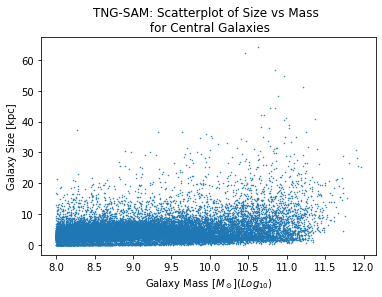

In [43]:
plt.plot(df_central_log['mstar_log'], df_central_log['half_radius'], '.', markersize=1)
plt.title('TNG-SAM: Scatterplot of Size vs Mass \n for Central Galaxies')
plt.xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
plt.ylabel('Galaxy Size [kpc]')
# plt.savefig("TNG-SAM_centrals_scatterplot_v3.jpeg", dpi=500)

plt.show()

## Correlations for all masses

In [44]:
df_central_log.head(2)

,mhalo,spin,Cnfw,Mhot,Macc,mstar,mHI,mH2,mbulge,r_bulge,...,half_radius,mstar_log,half_radius_log,mhalo_log,Mhot_log,mbulge_log,SFR_log,neutral_H_mass,baryon_mass,gas_fraction
53,4.502510e+09,0.03378,59.129101,9.503960e+09,0.0,1.050790e+08,2.710510e-11,0.0,72604704.0,0.503721,...,0.829693,8.021516,-0.081083,9.653455,9.977904,7.860965,-3.395986,2.710510e-11,1.050790e+08,2.579497e-19
59,1.285310e+11,0.03407,21.878799,8.516240e+05,0.0,2.136860e+09,4.310100e+08,145516000.0,231256000.0,1.340100,...,2.332662,9.329776,0.367852,11.109008,5.930248,8.364093,-0.994489,5.765260e+08,2.713386e+09,2.124747e-01


In [45]:
# central_SIMBA = df_SIMBA_largebin.loc[df_SIMBA_largebin["galaxy_type"] == 'central',["galaxy_mass_log", "galaxy_size_log",'SFR', 'SFR_log', 'atomic_H_mass', 'molecular_H_mass','gas_fraction','BoverT', 'galaxy_angular_momentum',"galaxy_angular_momentum_log",'Mhalo_log', 'Shalo']]
# print(central_SIMBA.shape)
central_galaxies_mass=df_central_log["mstar_log"]
central_galaxies_size=df_central_log["half_radius"]
central_galaxies_size_log=df_central_log["half_radius_log"]
central_galaxies_SFR=df_central_log["sfr"]
central_galaxies_SFR_log=df_central_log["SFR_log"]
central_galaxies_atomic_H_mass=df_central_log["mHI"]
central_galaxies_molecular_H_mass=df_central_log["mH2"]
central_galaxies_gas_fraction=df_central_log["gas_fraction"]
central_galaxies_halo_angular_momentum=df_central_log["spin"]
central_galaxies_Mhalo=df_central_log["mhalo_log"]

In [46]:
mass_size_corr_central = round(stats.spearmanr(central_galaxies_mass, central_galaxies_size)[0], 2)
SFR_size_corr_central = round(stats.spearmanr(central_galaxies_SFR_log, central_galaxies_size )[0], 2)
SFR_mass_corr_central = round(stats.spearmanr(central_galaxies_SFR_log, central_galaxies_mass )[0], 2)
mom_size_corr_central = round(stats.spearmanr(central_galaxies_halo_angular_momentum, central_galaxies_size)[0], 2)


In [47]:
mass_size_corr_central

0.27

In [48]:
mom_size_corr_central

0.62

In [49]:
SFR_mass_corr_central

0.77

In [50]:
SFR_size_corr_central

0.19

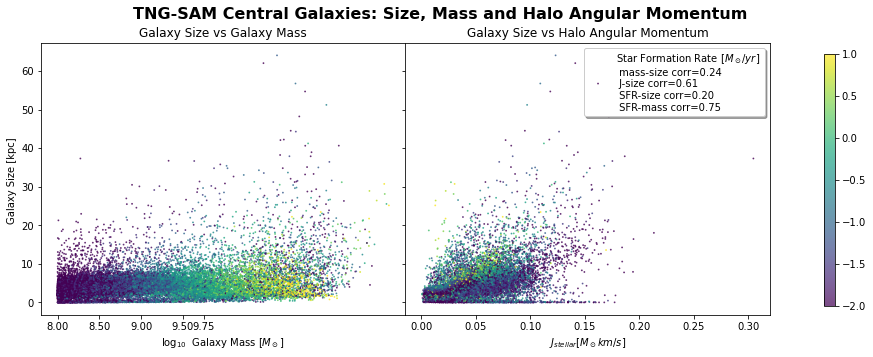

In [51]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(15,5))
fig.suptitle('TNG-SAM Central Galaxies: Size, Mass and Halo Angular Momentum  ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

# label = 'Star Formation Rate [$M_\odot / yr$] \n mass-size corr={} \n SFR-size corr={} \n SFR-mass corr={}'.format(10, mass_size_corr_central,SFR_size_corr_central,SFR_mass_corr_central )
# print(label)
im1 = ax1.scatter(df_central_log['mstar_log'], df_central_log['half_radius'], 
                  c = (df_central_log['SFR_log']),  s=3, marker='.', alpha=0.7 , vmin=-2, vmax=1.0)#, label=label)
# ax1.set_xlim([9.0, 11.5])
ax1.set_xticks([8.0, 8.5, 9.0, 9.5, 9.75])
# ax1.set_ylim([0.2,1.2])
ax1.set_title('Galaxy Size vs Galaxy Mass')
ax1.set_xlabel('$\log_{10} $  Galaxy Mass $[M_\odot] $')
ax1.set_ylabel('Galaxy Size [kpc] ')
# ax1.legend(loc='lower right', shadow=True)
# fig.colorbar(im1, ax=ax1)

label = 'Star Formation Rate [$M_\odot / yr$] \n mass-size corr=0.24 \n J-size corr=0.61 \n SFR-size corr=0.20 \n SFR-mass corr=0.75'
im2 = ax2.scatter(df_central_log['spin'], df_central_log['half_radius'], 
                  c = (df_central_log['SFR_log']),  s=3, marker='.', alpha=0.7,label= label, vmin=-2, vmax=1.0)
                  
# ax2.set_xlim([9,15])
ax2.set_xticks([ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
# ax2.set_ylim([-3.0, 1.1])
ax2.set_title('Galaxy Size vs Halo Angular Momentum')
ax2.set_xlabel('$ \, J_{stellar} [M_\odot km/s]$')
# ax2.set_ylabel('$\log_{10} \, \, Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='upper right' , shadow=True)
# fig.colorbar(im2, ax=ax2)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG-SAM_centrals_Mass_Size_AngMom_v4.jpeg", dpi=500)
plt.show()

In [52]:
df_central_log.columns.tolist()

['mhalo',
 'spin',
 'Cnfw',
 'Mhot',
 'Macc',
 'mstar',
 'mHI',
 'mH2',
 'mbulge',
 'r_bulge',
 'r_disk',
 'sfr',
 'Zcold',
 'Zstar',
 'sat_type',
 'half_radius',
 'mstar_log',
 'half_radius_log',
 'mhalo_log',
 'Mhot_log',
 'mbulge_log',
 'SFR_log',
 'neutral_H_mass',
 'baryon_mass',
 'gas_fraction']

In [53]:
df_central_log_pairplot = df_central_log.loc[:,["half_radius", "mstar_log", 
                                                'mhalo_log','spin', 'SFR_log', 'gas_fraction', 'Mhot_log', 
                                                "Cnfw", 'mbulge_log', 'Zcold', 'Zstar']]

In [54]:
df_central_log_pairplot.shape

(35390, 11)

### <font color='violet'> Last df saved as csv to experiment with ML models only from here on


In [55]:
# df_central_log_pairplot.to_csv('df_central_log_pairplot_all35000centrals.csv', index=False)

In [80]:
df_central_log_pairplot = pd.read_csv ('df_central_log_pairplot.csv') # df here read from the csv in previous line

In [81]:
df_central_log_pairplot.head(2)  

,half_radius,mstar_log,mhalo_log,spin,SFR_log,gas_fraction,Mhot_log,Cnfw,mbulge_log,Zcold,Zstar
0,2.332662,9.329776,11.109008,0.03407,-0.994489,0.212475,5.930248,21.8788,8.364093,0.206532,0.485612
1,2.922134,9.199695,11.068902,0.01407,-1.541164,0.181897,5.747273,23.4472,8.381359,0.099900,0.308089


In [82]:
df_sample = df_central_log_pairplot.sample(n = 1000, random_state = 2022) #choose a subset of data to use for pairplot

In [83]:
df_sample.shape

(1000, 11)

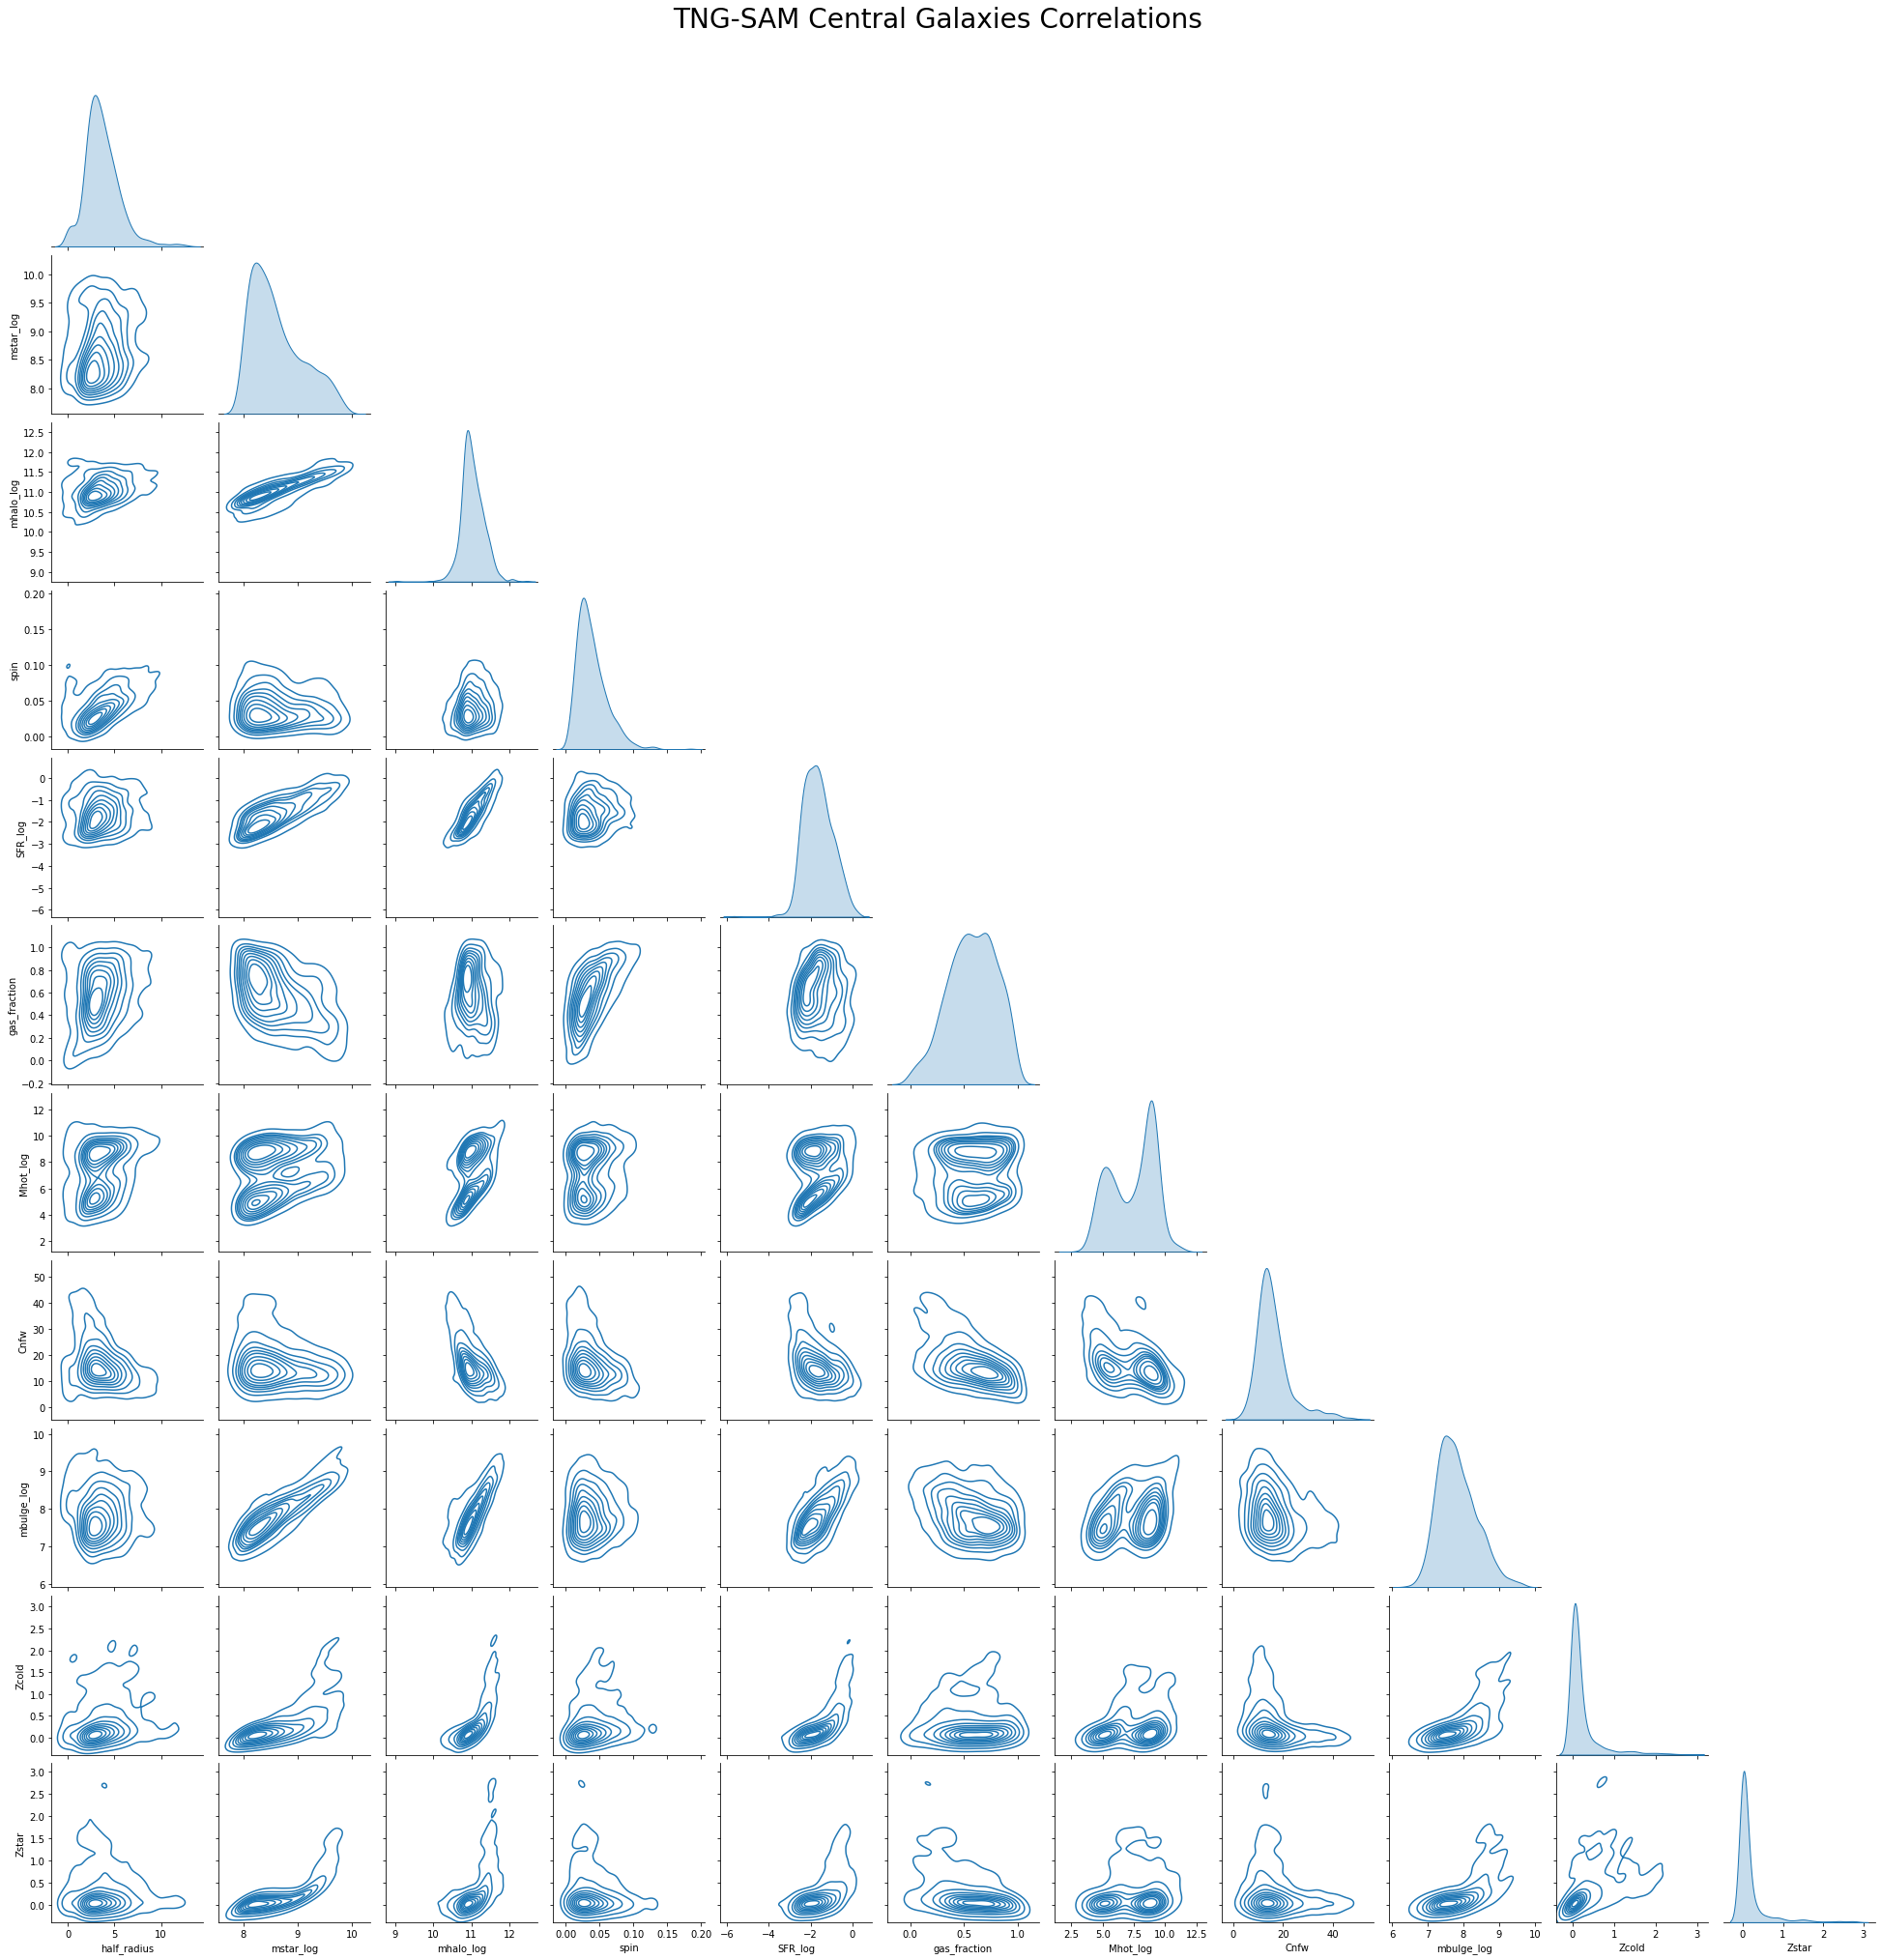

In [84]:
plot2=sns.pairplot(df_sample, kind='kde', corner=True)
plot2.fig.suptitle("TNG-SAM Central Galaxies Correlations ", y=1.03, fontsize=28) # y= some height>1
# plt.savefig("TNG-SAM_centrals_correlations_v2.pdf", dpi=500)
plt.show()


### <font color='blue'> 1. a. Linear Regression Model - all features

In [85]:
df_central_log_pairplot.columns

Index(['half_radius', 'mstar_log', 'mhalo_log', 'spin', 'SFR_log',
       'gas_fraction', 'Mhot_log', 'Cnfw', 'mbulge_log', 'Zcold', 'Zstar'],
      dtype='object')

In [86]:
X = df_central_log_pairplot.loc[:, ['mstar_log', 'mhalo_log', 'spin', 'SFR_log', 'gas_fraction' , 'Mhot_log', 'Cnfw', 'mbulge_log','Zcold', 'Zstar']]


y = df_central_log_pairplot.loc[:,'half_radius']

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [88]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

0.6058041356971973

In [89]:
reg.score(X_test, y_test)

0.5998845912414195

In [90]:
# y_pred_reg=reg.predict(X_test)
y_pred_reg = cross_val_predict(reg, X_test, y_test, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [91]:
y_pred_reg

array([3.93293357, 3.65957005, 4.64158736, ..., 4.80339168, 2.22334428,
       4.34160101])

In [92]:
reg.feature_names_in_

array(['mstar_log', 'mhalo_log', 'spin', 'SFR_log', 'gas_fraction',
       'Mhot_log', 'Cnfw', 'mbulge_log', 'Zcold', 'Zstar'], dtype=object)

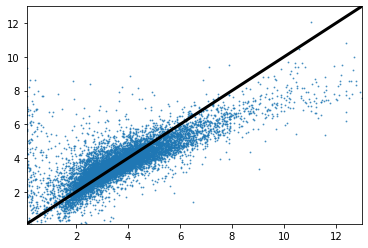

In [93]:
plt.scatter(y_test, y_pred_reg, s=3, marker='.', alpha=0.7)
plt.axis([0.1,13, 0.1,13])
# plt.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='-', color='k', lw=3, scalex=False, scaley=False)
plt.show()

In [94]:
slope, intercept = reg.coef_, reg.intercept_

In [95]:
slope, intercept

(array([ 5.32993268e+00,  7.78030502e-01,  4.18836256e+01, -1.83044037e+00,
         2.26301461e+00, -1.38251531e-03, -4.20672747e-02, -2.41654754e+00,
         5.31599646e-01, -8.08932858e-01]),
 -37.15867094107498)

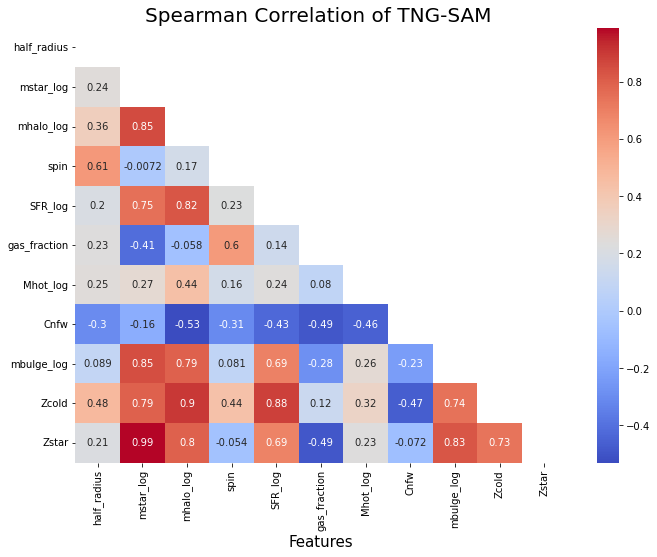

In [96]:
corr_df = df_central_log_pairplot.corr('spearman')
plt.figure(figsize=(11,8))
matrix = np.triu(corr_df) # take upper correlation matrix
sns.heatmap(corr_df, cmap="coolwarm",annot=True, mask=matrix)
plt.title("Spearman Correlation of TNG-SAM ", fontsize = 20)
plt.xlabel("Features", fontsize = 15)
# plt.savefig('TNG-SAM_Spearman_correlation_matrix.jpeg', dpi=500)
plt.show()

In [97]:
# X.corr()[X.corr()>.2]

### <font color='blue'> 2. Support Vector Machine (SVM)

In [98]:
regr_SVM = svm.SVR(kernel='rbf', degree=3,C=1000, verbose=True)
regr_SVM.fit(X_train,y_train)
y_pred = regr_SVM.predict(X_test)
print(r2_score(y_test,y_pred))

[LibSVM].............................................................................................................................................................................................................................................................................................................................................................................................................*............................................................................................................................................................................................................................................................................................................................*.....................................................................................................................................................................................................................................................................................

In [99]:
y_train_arr=np.array(y_train)

In [100]:
y_train_arr.reshape(-1, 1)

array([[2.75348939],
       [2.18621298],
       [2.81767602],
       ...,
       [1.08186116],
       [4.01266711],
       [1.49248638]])

In [101]:
y_test_arr=np.array(y_test)

In [102]:
y_test_arr

array([3.6301265 , 4.4852543 , 3.44807803, ..., 4.52526311, 1.81908223,
       2.68209438])

In [103]:
y_test_arr.reshape(-1, 1)

array([[3.6301265 ],
       [4.4852543 ],
       [3.44807803],
       ...,
       [4.52526311],
       [1.81908223],
       [2.68209438]])

In [104]:
from sklearn.preprocessing import StandardScaler, RobustScaler


scaler=StandardScaler()

# X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

y_train_scaled = scaler.fit_transform(y_train_arr.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test_arr.reshape(-1, 1))


In [105]:
X_train_scaled

array([[-0.68158287, -1.7058531 , -0.18484564, ..., -0.35461566,
        -0.530377  , -0.39314213],
       [ 1.346576  ,  2.3946326 , -0.18300298, ...,  1.9653308 ,
         3.0041246 ,  0.05222697],
       [-1.2240783 , -0.88848615, -0.534965  , ..., -0.96489745,
        -0.52130723, -0.41202924],
       ...,
       [-1.0856401 ,  0.6066555 ,  0.9843682 , ..., -0.07320236,
        -0.2123174 , -0.41686073],
       [ 0.28603467,  0.1666652 , -0.19129522, ...,  0.5245599 ,
        -0.38222098, -0.27040154],
       [-0.8002391 , -0.48635826, -0.59485376, ...,  0.0532635 ,
        -0.520706  , -0.40004265]], dtype=float32)

In [106]:
regr_SVM = svm.SVR(kernel='rbf',C=1000, verbose=True)

regr_SVM.fit(X_train_scaled,y_train_scaled)
y_pred_scaled = regr_SVM.predict(X_test_scaled)
print(r2_score(y_test_scaled,y_pred_scaled))

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibSVM]................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [ ]:
benchmark_lim_piped

In [ ]:
np.round(benchmark_lim_piped['test_score'].mean(),3), np.round(benchmark_lim_piped['test_score'].std(), 3)

In [117]:
from sklearn.svm import SVR

In [118]:

piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

{'memory': None,
 'steps': [('standardscaler', StandardScaler()), ('svr', SVR())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'svr': SVR(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'svr__C': 1.0,
 'svr__cache_size': 200,
 'svr__coef0': 0.0,
 'svr__degree': 3,
 'svr__epsilon': 0.1,
 'svr__gamma': 'scale',
 'svr__kernel': 'rbf',
 'svr__max_iter': -1,
 'svr__shrinking': True,
 'svr__tol': 0.001,
 'svr__verbose': False}

In [122]:
np.array(y_train)

array([2.75348939, 2.18621298, 2.81767602, ..., 1.08186116, 4.01266711,
       1.49248638])

In [127]:
#optimizing SVR

parameters = {'svr__kernel':['poly', 'rbf'], \
              'svr__gamma':[0.00001,'scale', 0.01, 0.1], 'svr__C':[0.1, 1.0, 1000], \
              'svr__degree': [2, 3]}

model = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True)

model.fit(X_train, y_train)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END svr__C=0.1, svr__degree=2, svr__gamma=1e-05, svr__kernel=poly; total time=   5.3s
[CV] END svr__C=0.1, svr__degree=2, svr__gamma=1e-05, svr__kernel=rbf; total time=   8.9s
[CV] END svr__C=0.1, svr__degree=2, svr__gamma=scale, svr__kernel=poly; total time=   5.6s
[CV] END svr__C=0.1, svr__degree=2, svr__gamma=scale, svr__kernel=poly; total time=   6.0s
[CV] END svr__C=0.1, svr__degree=2, svr__gamma=scale, svr__kernel=rbf; total time=   7.0s
[CV] END svr__C=0.1, svr__degree=2, svr__gamma=1e-05, svr__kernel=poly; total time=   5.3s
[CV] END svr__C=0.1, svr__degree=2, svr__gamma=1e-05, svr__kernel=poly; total time=   5.6s
[CV] END svr__C=0.1, svr__degree=2, svr__gamma=1e-05, svr__kernel=rbf; total time=   9.2s
[CV] END svr__C=0.1, svr__degree=2, svr__gamma=scale, svr__kernel=poly; total time=   5.8s
[CV] END svr__C=0.1, svr__degree=2, svr__gamma=scale, svr__kernel=rbf; total time=   7.0s
[CV] END svr__C=0.1, svr__degree

[CV] END svr__C=1000, svr__degree=2, svr__gamma=1e-05, svr__kernel=poly; total time=   6.9s
[CV] END svr__C=1000, svr__degree=2, svr__gamma=1e-05, svr__kernel=rbf; total time=  10.7s
[CV] END svr__C=1000, svr__degree=2, svr__gamma=scale, svr__kernel=poly; total time= 8.4min
[CV] END svr__C=1000, svr__degree=2, svr__gamma=scale, svr__kernel=rbf; total time=12.5min
[CV] END svr__C=1000, svr__degree=2, svr__gamma=0.01, svr__kernel=poly; total time=  13.3s
[CV] END svr__C=1000, svr__degree=2, svr__gamma=0.01, svr__kernel=poly; total time=  12.8s
[CV] END svr__C=1000, svr__degree=2, svr__gamma=0.01, svr__kernel=rbf; total time= 1.4min
[CV] END svr__C=1000, svr__degree=2, svr__gamma=0.01, svr__kernel=rbf; total time= 1.3min
[CV] END svr__C=1000, svr__degree=2, svr__gamma=0.01, svr__kernel=rbf; total time= 1.4min
[CV] END svr__C=1000, svr__degree=2, svr__gamma=0.1, svr__kernel=poly; total time= 8.4min
[CV] END svr__C=1000, svr__degree=2, svr__gamma=0.1, svr__kernel=rbf; total time=12.6min
[CV

Best params, best score: 0.8893 {'svr__C': 1000, 'svr__degree': 2, 'svr__gamma': 0.1, 'svr__kernel': 'rbf'}


In [128]:
scores_lim = pd.DataFrame(model.cv_results_)

scores_lim[['params','mean_test_score','std_test_score','mean_train_score', \
            'mean_fit_time']].sort_values(by = 'mean_test_score', ascending = False)

,params,mean_test_score,std_test_score,mean_train_score,mean_fit_time
47,"{'svr__C': 1000, 'svr__degree': 3, 'svr__gamma...",0.889288,0.010623,0.967759,717.593023
39,"{'svr__C': 1000, 'svr__degree': 2, 'svr__gamma...",0.889288,0.010623,0.967759,748.139834
35,"{'svr__C': 1000, 'svr__degree': 2, 'svr__gamma...",0.889286,0.010623,0.967759,738.702455
43,"{'svr__C': 1000, 'svr__degree': 3, 'svr__gamma...",0.889286,0.010623,0.967759,727.981252
27,"{'svr__C': 1.0, 'svr__degree': 3, 'svr__gamma'...",0.862494,0.006678,0.874628,5.671971
19,"{'svr__C': 1.0, 'svr__degree': 2, 'svr__gamma'...",0.862494,0.006678,0.874628,5.162164
31,"{'svr__C': 1.0, 'svr__degree': 3, 'svr__gamma'...",0.862494,0.006678,0.874627,5.306668
23,"{'svr__C': 1.0, 'svr__degree': 2, 'svr__gamma'...",0.862494,0.006678,0.874627,5.116564
45,"{'svr__C': 1000, 'svr__degree': 3, 'svr__gamma...",0.823342,0.120602,0.903024,78.469922
37,"{'svr__C': 1000, 'svr__degree': 2, 'svr__gamma...",0.823342,0.120602,0.903024,80.357061


In [130]:
scores_lim[scores_lim['param_svr__kernel'] == 'rbf'][['params','mean_test_score','std_test_score',\
                        'mean_train_score','mean_fit_time']].sort_values(by = 'mean_test_score', ascending = False)

,params,mean_test_score,std_test_score,mean_train_score,mean_fit_time
47,"{'svr__C': 1000, 'svr__degree': 3, 'svr__gamma...",0.889288,0.010623,0.967759,717.593023
39,"{'svr__C': 1000, 'svr__degree': 2, 'svr__gamma...",0.889288,0.010623,0.967759,748.139834
43,"{'svr__C': 1000, 'svr__degree': 3, 'svr__gamma...",0.889286,0.010623,0.967759,727.981252
35,"{'svr__C': 1000, 'svr__degree': 2, 'svr__gamma...",0.889286,0.010623,0.967759,738.702455
19,"{'svr__C': 1.0, 'svr__degree': 2, 'svr__gamma'...",0.862494,0.006678,0.874628,5.162164
27,"{'svr__C': 1.0, 'svr__degree': 3, 'svr__gamma'...",0.862494,0.006678,0.874628,5.671971
23,"{'svr__C': 1.0, 'svr__degree': 2, 'svr__gamma'...",0.862494,0.006678,0.874627,5.116564
31,"{'svr__C': 1.0, 'svr__degree': 3, 'svr__gamma'...",0.862494,0.006678,0.874627,5.306668
45,"{'svr__C': 1000, 'svr__degree': 3, 'svr__gamma...",0.823342,0.120602,0.903024,78.469922
37,"{'svr__C': 1000, 'svr__degree': 2, 'svr__gamma...",0.823342,0.120602,0.903024,80.357061


In [ ]:
scores_lim.columns

In [ ]:
stop here

In [ ]:
cv_score = cross_val_score(regr_SVM, X, y, cv=5)

In [ ]:
cv_score

In [ ]:
### Hyperparameter tuning

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]
# number of features at every split
# max_features = ['auto', 'sqrt']


# create random grid
grid = {'bootstrap': [True],
               'max_depth': [5, 10, None],
#                'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
#                'min_samples_split': [2, 5, 10],
               'n_estimators': n_estimators}
# Random search of parameters
rfr_grid = GridSearchCV(estimator = regr, param_grid = grid, cv = 3, verbose=2, n_jobs = -1)
# Fit the model
rfr_grid.fit(X_train, y_train)
# print results
print(rfr_grid.best_params_)



In [ ]:
#  y_pred = rfr_grid.best_estimator_.predict(X_test)
y_pred = cross_val_predict(regr_SVM, X_test, y_test, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [ ]:
y_pred

In [ ]:
cv_score = cross_val_score(regr_SVM, X, y, cv=5) # cv score in all data?

In [ ]:
cv_score

In [ ]:
y_pred_cv = cross_val_predict(regr_SVM, X_test, y_test, cv=3)


In [ ]:
plt.scatter(y_test, y_pred_cv, s=3, marker='.', alpha=0.7)
plt.axis([0.1,13, 0.1,13])
plt.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
plt.show()

In [ ]:
plt.scatter(y_test, y_pred, s=3, marker='.', alpha=0.7)
plt.axis([0.1,13, 0.1,13])
plt.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
plt.title('Prediction vs True Value with RF & all features ')
plt.xlabel('True Galaxy Size  [kpc] ')
plt.ylabel(' Predicted Galaxy Size  [kpc]  ')
# plt.savefig('Prediction_vs_True.jpeg', dpi=500)
# xpoints = ypoints = plt.xlim()
# plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
plt.show()

In [ ]:
regr_SVM.score(X_test,y_test)

In [ ]:
regr_SVM.score(X_train,y_train)

### Feature Importances MDI

In [ ]:
import time

start_time = time.time()
importances = rfr_grid.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr_grid.best_estimator_.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

In [ ]:
from sklearn.inspection import permutation_importance

feature_names = X_test.columns

forest_importances = pd.Series(importances, index=feature_names)

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('TNG-SAM Feature Importances  ', fontsize=16, fontweight='bold')

forest_importances.plot.bar(yerr=std, ax=ax1)
ax1.set_title("Feature importances using Mean Decrease in Impurity")
ax1.set_ylabel("Mean decrease in impurity")
# plt.savefig("Feature_Importances_MDI.jpeg", dpi=500)



### Feature Importances Permutation


start_time = time.time()
result = permutation_importance(
    rfr_grid.best_estimator_, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

forest_importances.plot.bar(yerr=result.importances_std, ax=ax2)
ax2.set_title("Feature importances using Permutation Importances ")
ax2.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
# plt.savefig("Feature_Importances_Permutation.jpeg", dpi=500)

plt.show()

### <font color='blue'> 1. b. Linear Regression Model - only STELLAR mass_log 

In [ ]:
X_train_stellar_mass = X_train.loc[:, ['mstar_log']]

In [ ]:
X_train_stellar_mass.head(2)

In [ ]:
X_test_stellar_mass = X_test.loc[:, ['mstar_log']]

In [ ]:
X_test_stellar_mass.shape

In [ ]:
reg_stellar_mass = LinearRegression().fit(X_train_stellar_mass, y_train)
reg_stellar_mass.score(X_train_stellar_mass, y_train)

In [ ]:
reg_stellar_mass.score(X_test_stellar_mass, y_test)

In [ ]:
# y_pred_reg_stellar=reg_stellar_mass.predict(X_test_stellar_mass)
y_pred_reg_stellar = cross_val_predict(reg_stellar_mass, X_test_stellar_mass, y_test, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [ ]:
y_test.shape , y_pred_reg_stellar.shape

In [ ]:
plt.scatter(y_test, y_pred_reg_stellar, s=3, marker='.', alpha=0.7)
plt.axis([0.1,13, 0.1,13])
plt.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
plt.title('Prediction vs True Value w only Stellar Mass ')
plt.xlabel('True Galaxy Size  [kpc] ')
plt.ylabel(' Predicted Galaxy Size  [kpc]  ')
plt.show()

In [ ]:
slope_stellar_mass, intercept_stellar_mass = reg_stellar_mass.coef_, reg_stellar_mass.intercept_

In [ ]:
slope_stellar_mass, intercept_stellar_mass

### <font color='blue'> 1. c. Linear Regression Model - only HALO mass_log 

In [ ]:
X_train_halo_mass = X_train.loc[:, ['mhalo_log']]

X_test_halo_mass = X_test.loc[:, ['mhalo_log']]

reg_halo_mass = LinearRegression().fit(X_train_halo_mass, y_train)
reg_halo_mass.score(X_train_halo_mass, y_train)

reg_halo_mass.score(X_test_halo_mass, y_test)

# y_pred_reg_halo=reg_halo_mass.predict(X_test_halo_mass)

y_pred_reg_halo = cross_val_predict(reg_halo_mass, X_test_halo_mass, y_test, cv = KFold(n_splits=5, shuffle=True, random_state=10))

plt.scatter(y_test, y_pred_reg_halo, s=3, marker='.', alpha=0.7)
plt.axis([0.1,13, 0.1,13])
plt.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
plt.title('Prediction vs True Value w only Halo Mass ')
plt.xlabel('True Galaxy Size  [kpc] ')
plt.ylabel(' Predicted Galaxy Size  [kpc]  ')
plt.show()

### <font color='blue'> 1. d. Linear Regression Model - only SPIN 

In [ ]:
X_train_spin = X_train.loc[:, ['spin']]

X_test_spin = X_test.loc[:, ['spin']]

reg_spin = LinearRegression().fit(X_train_spin, y_train)
reg_spin.score(X_train_spin, y_train)

reg_spin.score(X_test_spin, y_test)

# y_pred_reg_halo=reg_halo_mass.predict(X_test_halo_mass)

y_pred_reg_spin = cross_val_predict(reg_spin, X_test_spin, y_test, cv = KFold(n_splits=5, shuffle=True, random_state=10))

plt.scatter(y_test, y_pred_reg_spin, s=3, marker='.', alpha=0.7)
plt.axis([0.1,13, 0.1,13])
plt.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
plt.title('Prediction vs True Value w only Spin ')
plt.xlabel('True Galaxy Size  [kpc] ')
plt.ylabel(' Predicted Galaxy Size  [kpc]  ')
plt.show()

### <font color='blue'> 1. e. Linear Regression Model - only BULGE mass log

In [ ]:
X_train_bulge_mass = X_train.loc[:, ['mbulge_log']]

X_test_bulge_mass = X_test.loc[:, ['mbulge_log']]

reg_bulge_mass = LinearRegression().fit(X_train_bulge_mass, y_train)
reg_bulge_mass.score(X_train_bulge_mass, y_train)

reg_bulge_mass.score(X_test_bulge_mass, y_test)

# y_pred_reg_halo=reg_halo_mass.predict(X_test_halo_mass)

y_pred_reg_bulge = cross_val_predict(reg_bulge_mass, X_test_bulge_mass, y_test, cv = KFold(n_splits=5, shuffle=True, random_state=10))

plt.scatter(y_test, y_pred_reg_bulge, s=3, marker='.', alpha=0.7)
plt.axis([0.1,13, 0.1,13])
plt.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
plt.title('Prediction vs True Value w only Bulge Mass ')
plt.xlabel('True Galaxy Size  [kpc] ')
plt.ylabel(' Predicted Galaxy Size  [kpc]  ')
plt.show()

### The figure containing all the models

In [ ]:
fig,[(ax1, ax2), (ax3, ax4), (ax5, ax6)]=plt.subplots(nrows=3,ncols=2,figsize=(10,15))
fig.suptitle('TNG-SAM Central Galaxies Size Prediction', fontsize=16, fontweight='bold')


label = 'Train score={} \n Test score={}'.format(round(reg_stellar_mass.score(X_train_stellar_mass, y_train), 2),round(reg_stellar_mass.score(X_test_stellar_mass, y_test), 2) )
# print(label)
im1 = ax1.scatter(y_test, y_pred_reg_stellar, s=3, marker='.', alpha=0.7, label=label)
# ax1.set_xlim([9.0, 11.5])
# ax1.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax1.set_ylim([0.2,1.2])
ax1.axis([0.1,13, 0.1,13])
ax1.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
ax1.set_title('Linear Regression Model \n with only Stellar Mass')
ax1.set_xlabel('True Galaxy Size  [kpc]')
ax1.set_ylabel('Predicted Galaxy Size  [kpc] ')
ax1.legend(loc='lower right', shadow=True)


label = 'Train score={} \n Test score={}'.format(round(reg_halo_mass.score(X_train_halo_mass, y_train), 2),round(reg_halo_mass.score(X_test_halo_mass, y_test), 2) )
im2 = ax2.scatter(y_test, y_pred_reg_halo, s=3, marker='.', alpha=0.7, label=label)
# ax2.set_xlim([9.0, 11.5])
# ax2.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax2.set_ylim([0.2,1.2])
ax2.axis([0.1,13, 0.1,13])
ax2.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
ax2.set_title('Linear Regression Model \n with only Halo Mass ')
ax2.set_xlabel('True Galaxy Size  [kpc]')
ax2.set_ylabel('Predicted Galaxy Size  [kpc] ')
ax2.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(reg_bulge_mass.score(X_train_bulge_mass, y_train), 2),round(reg_bulge_mass.score(X_test_bulge_mass, y_test), 2) )
im3 = ax3.scatter(y_test, y_pred_reg_bulge, s=3, marker='.', alpha=0.7, label=label)
# ax3.set_xlim([9.0, 11.5])
# ax3.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax3.set_ylim([0.2,1.2])
ax3.axis([0.1,13, 0.1,13])
ax3.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
ax3.set_title('Linear Regression Model \n with only Bulge Mass')
ax3.set_xlabel('True Galaxy Size  [kpc]')
ax3.set_ylabel('Predicted Galaxy Size  [kpc] ')
ax3.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(reg_spin.score(X_train_spin, y_train), 2),round(reg_spin.score(X_test_spin, y_test), 2) )
im4 = ax4.scatter(y_test, y_pred_reg_spin, s=3, marker='.', alpha=0.7, label=label)
# ax4.set_xlim([9.0, 11.5])
# ax4.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax4.set_ylim([0.2,1.2])
ax4.axis([0.1,13, 0.1,13])
ax4.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
ax4.set_title('Linear Regression Model \n with only Spin')
ax4.set_xlabel('True Galaxy Size  [kpc]')
ax4.set_ylabel('Predicted Galaxy Size  [kpc] ')
ax4.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(reg.score(X_train, y_train), 2),round(reg.score(X_test, y_test), 2) )
im5 = ax5.scatter(y_test, y_pred_reg, s=3, marker='.', alpha=0.7, label=label)
# ax5.set_xlim([9.0, 11.5])
# ax5.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax5.set_ylim([0.2,1.2])
ax5.axis([0.1,13, 0.1,13])
ax5.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
ax5.set_title('Linear Regression Model \n with all the features')
ax5.set_xlabel('True Galaxy Size  [kpc]')
ax5.set_ylabel('Predicted Galaxy Size  [kpc] ')
ax5.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(rfr_grid.best_estimator_.score(X_train,y_train), 2),round(rfr_grid.best_estimator_.score(X_test,y_test), 2) )
im6 = ax6.scatter(y_test, y_pred, s=3, marker='.', alpha=0.7, label=label)
# ax6.set_xlim([9.0, 11.5])
# ax6.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax6.set_ylim([0.2,1.2])
ax6.axis([0.1,13, 0.1,13])
ax6.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
ax6.set_title('Random Forest Regressor Model \n with all the features')
ax6.set_xlabel('True Galaxy Size  [kpc]')
ax6.set_ylabel('Predicted Galaxy Size  [kpc] ')
ax6.legend(loc='lower right', shadow=True)
    
# grid = plt.GridSpec(3, 2)
# create_subtitle(fig, grid[0, ::], 'Linear Regression with only Stellar Mass as a feature')
# create_subtitle(fig, grid[1, ::], 'Linear Regression with only Halo Mass as a feature')
# create_subtitle(fig, grid[2, ::], 'Linear Regression vs Random Forest Regressor with all features')

fig.subplots_adjust(top=0.95, hspace=0.5, wspace=0.5)
fig.tight_layout()
# plt.savefig("TNG-SAM_central_size_prediction.jpeg", dpi=500)
plt.show()

### <font color='blue'> 2.a. Random Forest Model eliminating features

In [ ]:
X_el = df_central_log_pairplot.loc[:, ['mstar_log', 'mhalo_log', 'spin', 'SFR_log', 'gas_fraction' , 'Mhot_log', 'mbulge_log','Zcold', 'Zstar']]


y_el = df_central_log_pairplot.loc[:,'half_radius']

In [ ]:
corr_el = X_el.corr('spearman')
plt.figure(figsize=(11,8))
matrix = np.triu(corr_el) # take upper correlation matrix
sns.heatmap(corr_el, cmap="coolwarm",annot=True, mask=matrix)
plt.title("Spearman Correlation of TNG-SAM features - Cnfw", fontsize = 20)
plt.xlabel("Features", fontsize = 15)
# plt.savefig('TNG-SAM_Spearman_correlation_matrix.jpeg', dpi=500)
plt.show()

In [ ]:
X_train_el, X_test_el, y_train_el, y_test_el = train_test_split(X_el, y_el, test_size=0.33, random_state=42)

In [ ]:
regr_el = RandomForestRegressor(max_depth=10, random_state=0)

In [ ]:
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]
# number of features at every split
# max_features = ['auto', 'sqrt']


# create random grid
grid = {'bootstrap': [True],
               'max_depth': [5, 10, None],
#                'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
#                'min_samples_split': [2, 5, 10],
               'n_estimators': n_estimators}
# Random search of parameters
rfr_grid_el = GridSearchCV(estimator = regr_el, param_grid = grid, cv = 3, verbose=2, n_jobs = -1)
# Fit the model
rfr_grid_el.fit(X_train_el, y_train_el)
# print results
print(rfr_grid_el.best_params_)

In [ ]:
#  y_pred = rfr_grid.best_estimator_.predict(X_test)
y_pred_el = cross_val_predict(rfr_grid_el.best_estimator_, X_test_el, y_test_el, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [ ]:
label = 'Train score={} \n Test score={}'.format(round(rfr_grid_el.best_estimator_.score(X_train_el, y_train_el), 2),round(rfr_grid_el.score(X_test_el, y_test_el), 2) )
plt.scatter(y_test, y_pred_el, s=3, marker='.', alpha=0.7, label=label)
plt.axis([0.1,13, 0.1,13])
plt.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
plt.title('Prediction vs True Value with RF & all-Cnfw features ')
plt.xlabel('True Galaxy Size  [kpc] ')
plt.ylabel(' Predicted Galaxy Size  [kpc]  ')
plt.legend(loc='lower right')
# plt.savefig('TNG-SAM_Prediction_vs_True_without_Cnfw.jpeg', dpi=500)
plt.show()

In [ ]:
start_time = time.time()
importances_el = rfr_grid_el.best_estimator_.feature_importances_
std_el = np.std([tree.feature_importances_ for tree in rfr_grid_el.best_estimator_.estimators_], axis=0)
elapsed_time = time.time() - start_time

In [ ]:
feature_names_el = X_test_el.columns

forest_importances_el = pd.Series(importances_el, index=feature_names_el)

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('TNG-SAM Feature Importances without Cnfw ', fontsize=16, fontweight='bold')

forest_importances_el.plot.bar(yerr=std_el, ax=ax1)
ax1.set_title("Feature importances using Mean Decrease in Impurity")
ax1.set_ylabel("Mean decrease in impurity")
# plt.savefig("Feature_Importances_MDI.jpeg", dpi=500)

### Feature Importances Permutation

start_time = time.time()
result_el = permutation_importance(
    rfr_grid_el.best_estimator_, X_test_el, y_test_el, n_repeats=10, random_state=0, n_jobs=-1
)
elapsed_time = time.time() - start_time
# print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances_el = pd.Series(result_el.importances_mean, index=feature_names_el)

forest_importances_el.plot.bar(yerr=result_el.importances_std, ax=ax2)
ax2.set_title("Feature importances using Permutation Importances ")
ax2.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
# plt.savefig("Feature_Importances_Permutation_without_Cnfw.jpeg", dpi=500)

plt.show()

### <font color='blue'> 2.b. Random Forest Model eliminating features

In [ ]:
# X_el = df_central_log_pairplot.loc[:, ['spin', 'mbulge_log']]
# X_el = df_central_log_pairplot.loc[:, ['mstar_log', 'mhalo_log', 'spin', 'SFR_log', 'gas_fraction' , 'Mhot_log', 'mbulge_log',]]
# X_el = df_central_log_pairplot.loc[:, ['mstar_log', 'mhalo_log', 'spin', 'SFR_log', 'mbulge_log',]]
# X_el = df_central_log_pairplot.loc[:, ['mstar_log', 'mhalo_log', 'spin', 'mbulge_log',]]
# X_el = df_central_log_pairplot.loc[:, ['mstar_log', 'spin', 'mbulge_log',]]
X_el = df_central_log_pairplot.loc[:, [ 'spin', 'mbulge_log',]]

y_el = df_central_log_pairplot.loc[:,'half_radius']

In [ ]:
corr_el = X_el.corr('spearman')
plt.figure(figsize=(11,8))
matrix = np.triu(corr_el) # take upper correlation matrix
sns.heatmap(corr_el, cmap="coolwarm",annot=True, mask=matrix)
plt.title("Spearman Correlation of TNG-SAM with only spin, mstar features", fontsize = 20)
plt.xlabel("Features", fontsize = 15)
# plt.savefig('TNG-SAM_Spearman_correlation_matrix.jpeg', dpi=500)
plt.show()

In [ ]:
X_train_el, X_test_el, y_train_el, y_test_el = train_test_split(X_el, y_el, test_size=0.33, random_state=42)

regr_el = RandomForestRegressor(max_depth=10, random_state=0)

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]
# number of features at every split
# max_features = ['auto', 'sqrt']


# create random grid
grid = {'bootstrap': [True],
               'max_depth': [5, 10, None],
#                'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
#                'min_samples_split': [2, 5, 10],
               'n_estimators': n_estimators}
# Random search of parameters
rfr_grid_el = GridSearchCV(estimator = regr_el, param_grid = grid, cv = 3, verbose=2, n_jobs = -1)
# Fit the model
rfr_grid_el.fit(X_train_el, y_train_el)
# print results
print(rfr_grid_el.best_params_)

#  y_pred = rfr_grid.best_estimator_.predict(X_test)
y_pred_el = cross_val_predict(rfr_grid_el.best_estimator_, X_test_el, y_test_el, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [ ]:
label = 'Train score={} \n Test score={}'.format(round(rfr_grid_el.best_estimator_.score(X_train_el, y_train_el), 2),round(rfr_grid_el.score(X_test_el, y_test_el), 2) )
plt.scatter(y_test, y_pred_el, s=3, marker='.', alpha=0.7, label=label)
plt.axis([0.1,13, 0.1,13])
plt.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
plt.title('Prediction vs True Value with RF, only  mbulge_log & mstar features ')
plt.xlabel('True Galaxy Size  [kpc] ')
plt.ylabel(' Predicted Galaxy Size  [kpc]  ')
plt.legend(loc='lower right')
# plt.savefig('TNG-SAM_Prediction_vs_True_with_mstar_spin_mbulge.jpeg', dpi=500)
plt.show()

In [ ]:
start_time = time.time()
importances_el = rfr_grid_el.best_estimator_.feature_importances_
std_el = np.std([tree.feature_importances_ for tree in rfr_grid_el.best_estimator_.estimators_], axis=0)
elapsed_time = time.time() - start_time

feature_names_el = X_test_el.columns

forest_importances_el = pd.Series(importances_el, index=feature_names_el)

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('TNG-SAM Feature Importances with only mstar, spin & mbulge features ', fontsize=16, fontweight='bold')

forest_importances_el.plot.bar(yerr=std_el, ax=ax1)
ax1.set_title("Feature importances using Mean Decrease in Impurity")
ax1.set_ylabel("Mean decrease in impurity")
# plt.savefig("Feature_Importances_MDI.jpeg", dpi=500)

### Feature Importances Permutation

start_time = time.time()
result_el = permutation_importance(
    rfr_grid_el.best_estimator_, X_test_el, y_test_el, n_repeats=10, random_state=0, n_jobs=-1
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances_el = pd.Series(result_el.importances_mean, index=feature_names_el)

forest_importances_el.plot.bar(yerr=result_el.importances_std, ax=ax2)
ax2.set_title("Feature importances using Permutation Importances ")
ax2.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
# plt.savefig("TNG-SAM_Feature_Importances_Permutation_with_mstar_spin_mbulge.jpeg", dpi=500)

plt.show()

In [ ]:
fig,[ax1, ax5, ax6 ]=plt.subplots(nrows=1,ncols=3,sharey=True, figsize=(15,5))
# fig.suptitle('SIMBA Central Galaxies Size Prediction', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

label = 'Train score={} \n Test score={}'.format(round(reg_stellar_mass.score(X_train_stellar_mass, y_train), 2),round(reg_stellar_mass.score(X_test_stellar_mass, y_test), 2) )
im1 = ax1.scatter(y_test, y_pred_reg_stellar, s=3, marker='.', alpha=0.7, label=label)
ax1.axis([0.1,1.3, 0.1,1.3])
ax1.plot([0.2, 1.2], [0.2, 1.2], color = 'black', linewidth = 2)
ax1.set_title('Linear Regression Model \n with only Stellar Mass')
ax1.set_xlabel('True $ log_{10} $ Galaxy Size  [kpc]')
ax1.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax1.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(reg.score(X_train, y_train), 2),round(reg.score(X_test, y_test), 2) )
im5 = ax5.scatter(y_test, y_pred_reg, s=3, marker='.', alpha=0.7, label=label)
ax5.axis([0.1,1.3, 0.1,1.3])
ax5.plot([0.2, 1.2], [0.2, 1.2], color = 'black', linewidth = 2)
ax5.set_title('Linear Regression Model \n with all the features')
ax5.set_xlabel('True $ log_{10} $ Galaxy Size  [kpc]')
# ax5.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax5.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(rfr_grid.best_estimator_.score(X_train,y_train), 2),round(rfr_grid.best_estimator_.score(X_test,y_test), 2) )
im6 = ax6.scatter(y_test, y_pred, s=3, marker='.', alpha=0.7, label=label)
ax6.axis([0.1,1.3, 0.1,1.3])
ax6.plot([0.2, 1.2], [0.2, 1.2], color = 'black', linewidth = 2)
ax6.set_title('Random Forest Regressor Model \n with all the features')
ax6.set_xlabel('True $ log_{10} $ Galaxy Size  [kpc]')
# ax6.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax6.legend(loc='lower right', shadow=True)
    
# grid = plt.GridSpec(3, 2)
# create_subtitle(fig, grid[0, ::], 'Linear Regression with only Stellar Mass as a feature')
# create_subtitle(fig, grid[1, ::], 'Linear Regression with only Halo Mass as a feature')
# create_subtitle(fig, grid[2, ::], 'Linear Regression vs Random Forest Regressor with all features')

# fig.subplots_adjust(hspace=0.0, wspace=0.0)
fig.tight_layout()
# plt.savefig("SIMBA_LR_vs_RF_size_prediction.jpeg", dpi=500)
plt.show()